# SARIMAX Forecaster - Generalizability Asssesment

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths
os.chdir("/Users/yuanliu/Documents/Erasmus University/MSc Quantitive Marketing and Business Analytics/P3/Seminar Case Study/Data/case_studies_ah/")

## Install Required Packages

In [2]:
pip install pmdarima --quiet


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: /Users/yuanliu/opt/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
from datetime import datetime
import datetime
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
import torch

In [4]:
plt.style.use('ggplot')

colors = plt.cm.Spectral(np.linspace(0,1,30))
plt.rcParams["figure.figsize"] = (20,5)

Select product type and country, choose from:

Product Type:
- SUNFLOWER OIL
- WHEAT
- MAIZE

Country:
- Germany
- Spain

Note: Mind the capital letters

In [5]:
product_type = "SUNFLOWER OIL"
country_filter = "Germany"
date_filter = datetime.date(year=2018, month=1, day=1)
date_end = datetime.date(year = 2022, month = 10, day = 1)

Load the data for the combination of country and product and transfer to workable format

In [15]:
if product_type == "WHEAT":
    trade_data = pd.read_csv("Data/wheat_similar_countries.csv")
    
if product_type == "MAIZE":
    trade_data = pd.read_csv("Data/maize_corn_similar_countries_new.csv")
    
if product_type == "SUNFLOWER OIL":
    trade_data = pd.read_csv("Data/sunflower_oil_similar_countries_new.csv")
    
# Add Time Period steps
trade_data["TIME_PERIOD"] = pd.to_datetime(trade_data["TIME_PERIOD"], format = '%Y-%m').dt.date
trade_data = trade_data.rename(columns={"partner": "PARTNER_codes", "declarant": "DECLARANT_codes"})

# Make sure that the right product is isolated
products = trade_data["product"].drop_duplicates().to_list()

if product_type == 'SUNFLOWER OIL' or product_type == 'MAIZE':
    product_filter = products[0]

if product_type == 'WHEAT':
    product_filter = products[0]
    
# Add correct labels to the partner and declarent indices
partner_countries = pd.read_csv("Data/partners.csv", sep = ";")
declarant_countries = pd.read_csv("Data/declarants.csv", sep = ";")
trade_data = pd.merge(trade_data, partner_countries, on = ['PARTNER_codes'], how = 'inner')
trade_data = pd.merge(trade_data, declarant_countries, on = ['DECLARANT_codes'], how = 'inner')


# Filter on correct declarant country
trade_data = trade_data[(trade_data["DECLARANT_Labels"] == country_filter)]

trade_data_pivot = trade_data.pivot(index=['PARTNER_Labels', 'TIME_PERIOD', 'product'], 
                              columns='indicators', 
                              values=['OBS_VALUE'])

trade_data_pivot.columns = trade_data_pivot.columns.map('_'.join)
trade_data_pivot = trade_data_pivot.reset_index()
trade_data_pivot = trade_data_pivot.dropna()


trade_data_total = trade_data_pivot\
.groupby(['product', 'TIME_PERIOD']).agg({'OBS_VALUE_QUANTITY_TON': 'sum', 
                                          'OBS_VALUE_VALUE_1000EURO': 'sum'})

trade_data_total = trade_data_total.reset_index()
trade_data_total['price'] = trade_data_total['OBS_VALUE_VALUE_1000EURO']/trade_data_total['OBS_VALUE_QUANTITY_TON']
trade_data_total = trade_data_total[(trade_data_total["product"] == product_filter)]

# Isolate Ukraine - Netherlands Import data for later use
Ukr_Data = trade_data_pivot[(trade_data_pivot['PARTNER_Labels']=='Ukraine') & (trade_data_pivot["product"] == product_filter) & (trade_data_pivot["TIME_PERIOD"] >= date_filter)][['TIME_PERIOD','OBS_VALUE_QUANTITY_TON']]
Ukr_Data = Ukr_Data.set_index("TIME_PERIOD")
Ukr_Data = Ukr_Data.rename(columns = {"OBS_VALUE_QUANTITY_TON" : "UKR_QUANTITY"})
trade_data_total['UKR_QUANTITY'] = Ukr_Data['UKR_QUANTITY']
trade_data_total = trade_data_total.fillna(0)

trade_data_total = trade_data_total.set_index("TIME_PERIOD")
trade_data_total = trade_data_total[(trade_data_total.index >= date_filter)]

# Import other commodities and use same procedure
oil_data = pd.read_csv("Data/CMO-Historical-Data-Monthly.csv", header = 6)
oil_data = oil_data.rename(columns = {"Unnamed: 0" : "TIME_PERIOD"})
oil_data['TIME_PERIOD'] = oil_data['TIME_PERIOD'].str.replace(r'M', '-')
oil_data["TIME_PERIOD"] = pd.to_datetime(oil_data["TIME_PERIOD"], format = '%Y-%m').dt.date
to_replace = oil_data["SUNFLOWER_OIL"].iloc[0]
oil_data = oil_data.replace(to_replace, 0)
oil_data = oil_data.drop_duplicates()
oil_data = oil_data.set_index("TIME_PERIOD")
oil_data = oil_data[(oil_data.index >= date_filter) & (oil_data.index <= date_end)]

trade_data_total = trade_data_total.reset_index()
oil_data = oil_data.reset_index()

data = trade_data_total.merge(oil_data, on = 'TIME_PERIOD')
data = data[data.columns.drop(list(data.filter(regex='Unnamed')))]
data = data.set_index("TIME_PERIOD")

In [16]:
data.head()

,product,OBS_VALUE_QUANTITY_TON,OBS_VALUE_VALUE_1000EURO,price,UKR_QUANTITY,CRUDE_PETRO,CRUDE_BRENT,CRUDE_DUBAI,CRUDE_WTI,COAL_AUS,...,ALUMINUM,IRON_ORE,COPPER,LEAD,Tin,NICKEL,Zinc,GOLD,PLATINUM,SILVER
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2018-01-01,15121191,25190.9,19640.93,0.779684,0.0,66.23,68.99,66.02,63.67,106.45,...,2209.73,76.34,7065.85,2584.09,20696.91,12864.88,3441.52,1331.30,990.12,17.13
2018-02-01,15121191,19837.6,15685.09,0.790675,0.0,63.46,65.42,62.79,62.17,105.95,...,2181.79,77.46,7006.52,2581.06,21651.55,13595.88,3532.90,1330.73,987.26,16.58
2018-03-01,15121191,25892.7,20644.07,0.797293,0.0,64.17,66.45,63.29,62.76,96.66,...,2069.24,70.35,6799.18,2390.00,21211.94,13392.50,3269.18,1324.66,954.57,16.47
2018-04-01,15121191,22773.7,16776.46,0.736659,0.0,68.79,71.63,68.43,66.32,93.69,...,2254.69,65.75,6851.51,2352.41,21291.10,13938.10,3188.05,1334.76,924.05,16.65
2018-05-01,15121191,19339.6,14475.19,0.748474,0.0,73.43,76.65,73.66,69.98,105.29,...,2299.67,66.10,6825.27,2360.93,20858.83,14366.49,3059.87,1303.45,904.73,16.49


## Forecaster Tool SARIMA
Define the number of in-sample months you want to forecast and find the optimal order combination with the pm.auto_arima tool

In [19]:
months_to_forecast = 7

test_training_split = datetime.date(year = 2022, month = 10 - months_to_forecast, day = 1)

training_data = data[(data.index <= test_training_split)]
test_data = data[(data.index > test_training_split)]

In [18]:
# SARIMAX Model
SARIMAX_model = pm.auto_arima(training_data['price'], exogenous=training_data[['NGAS_EUR', 'CRUDE_PETRO', 'UKR_QUANTITY']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True
                             )


KeyboardInterrupt



In [11]:
SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   51
Model:             SARIMAX(1, 2, 1)x(2, 1, 1, 12)   Log Likelihood                  50.607
Date:                            Wed, 15 Mar 2023   AIC                            -89.215
Time:                                    16:59:17   BIC                            -79.549
Sample:                                01-01-2018   HQIC                           -85.807
                                     - 03-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2802      0.177     -1.585      0.113      -0.627       0.066
ma.L1         -0.9390      0.281     -3.339      0.001      -1.490      -0.388
ar.S.L12      -0.3764      1.656     -0.227      0.820      -3.622       2.869
ar.S.L24      -0.5168      0.737     -0.701      0.483      -1.961       0.927
ma.S.L12      -0.8184     13.913     -0.059      0.953     -28.087      26.450
sigma2         0.0016      0.020      0.082      0.935      -0.037       0.040
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.26
Prob(Q):                              0.86   Prob(JB):                         0.53
Heteroskedasticity (H):               1.37   Skew:                             0.11
Prob(H) (two-sided):                  0.59   Kurtosis:                         2.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Set-up model and make predictions. Output quantile loss using the torch function from the TFT model.

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(training_data['price'], exog=training_data[['NGAS_EUR', 'CRUDE_PETRO', 'UKR_QUANTITY']], order=SARIMAX_model.order, seasonal_orderiterable = SARIMAX_model.seasonal_order, enforce_invertibility=False, enforce_stationarity=False)

results = model.fit(disp=0);

/Users/yuanliu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/yuanliu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/yuanliu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [13]:
test_size = len(test_data)
diff = 0
exog_dat = test_data[['NGAS_EUR', 'CRUDE_PETRO', 'UKR_QUANTITY']].head(test_size - diff)

predictions = results.forecast(steps=test_size-diff, exog=exog_dat)

forecast = results.get_prediction(end = len(training_data) + test_size - 1, exog = test_data[['NGAS_EUR', 'CRUDE_PETRO', 'UKR_QUANTITY']])
ci02 = forecast.conf_int(alpha = 0.02)
ci02 = ci02.rename(columns = {"lower price" : "ci02L", "upper price" : "ci02U"})
ci10 = forecast.conf_int(alpha = 0.10)
ci10 = ci10.rename(columns = {"lower price" : "ci10L", "upper price" : "ci10U"})
ci25 = forecast.conf_int(alpha = 0.5)
ci25 = ci25.rename(columns = {"lower price" : "ci25L", "upper price" : "ci25U"})
c50 = forecast.predicted_mean

cis = ((ci02.join(ci10)).join(ci25)).join(c50)

relevant_cis = cis.tail(months_to_forecast)

relevant_cis_unp = relevant_cis.reset_index()

preds_torch = []

for i in range(len(relevant_cis_unp)):
    preds_torch.append(sorted(relevant_cis_unp.loc[i, :].values.flatten().tolist()[1:]))

target_dat = data['price'].tail(months_to_forecast)

target = torch.FloatTensor(target_dat)
y_pred = torch.FloatTensor([preds_torch])
QLoss = torch.mean(QuantileLoss().loss(y_pred, target)).item()
print("Quantile Loss is: ", QLoss)

Quantile Loss is:  0.20933429896831512


## Plot Results

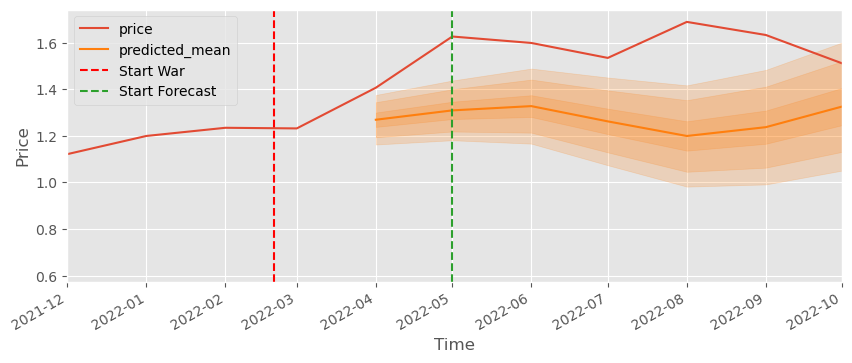

In [14]:
plt.rcParams["figure.figsize"] = (10,4)

ax = data['price'].plot()
relevant_cis[['predicted_mean']].plot(ax = ax, color = 'tab:orange', label = 'SARIMAX Prediction');
plt.xlim(
    xmin=datetime.datetime(2021, 12, 1), # the one that doesn't change
    xmax=datetime.datetime(2022, 10, 1) # the latest datetime in your dataset
)

plt.fill_between(relevant_cis.index, relevant_cis['ci02L'], relevant_cis['ci02U'], alpha = 0.2, color = 'tab:orange')
plt.fill_between(relevant_cis.index, relevant_cis['ci10L'], relevant_cis['ci10U'], alpha = 0.2, color = 'tab:orange')
plt.fill_between(relevant_cis.index, relevant_cis['ci25L'], relevant_cis['ci25U'], alpha = 0.2, color = 'tab:orange')

plt.axvline(datetime.datetime(2022, 2, 20), color = 'red', linestyle = '--', label = 'Start War')
plt.axvline(datetime.datetime(2022, 5, 1), color = 'tab:green',linestyle = '--', label = 'Start Forecast');
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend();

# plt.ylim(0,2)